In [ ]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
import math
import datetime as dt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 


In [ ]:
# 2. Đọc file dữ liệu chứng khoán AAPL và chia train test validate theo tỉ lệ 7:1:2
df = pd.read_csv('/content/Dữ-liệu-Lịch-sử-VNM.csv')
df = df[['Close']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

def stationarity(col):
    res = adfuller(col.dropna())
    print("Test Statistic:", res[0])
    print("P-Value:", res[1])
    if res[1] < 0.05:
        print("Stationary")
    else:
        print("Non-Stationary")

Test Statistic: -0.44415491407320823
P-Value: 0.902461372828952
Non-Stationary


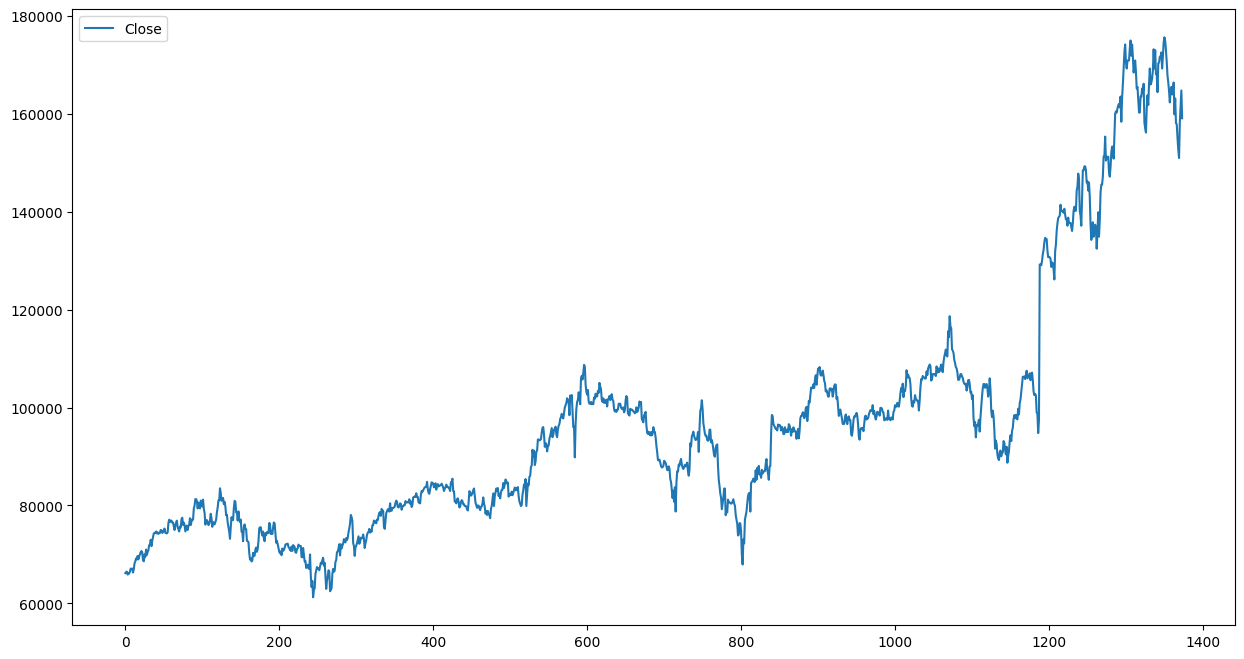

In [ ]:
df.plot(figsize=(15,8))

stationarity(df)

Test Statistic: -22.789475984405733
P-Value: 0.0
Stationary


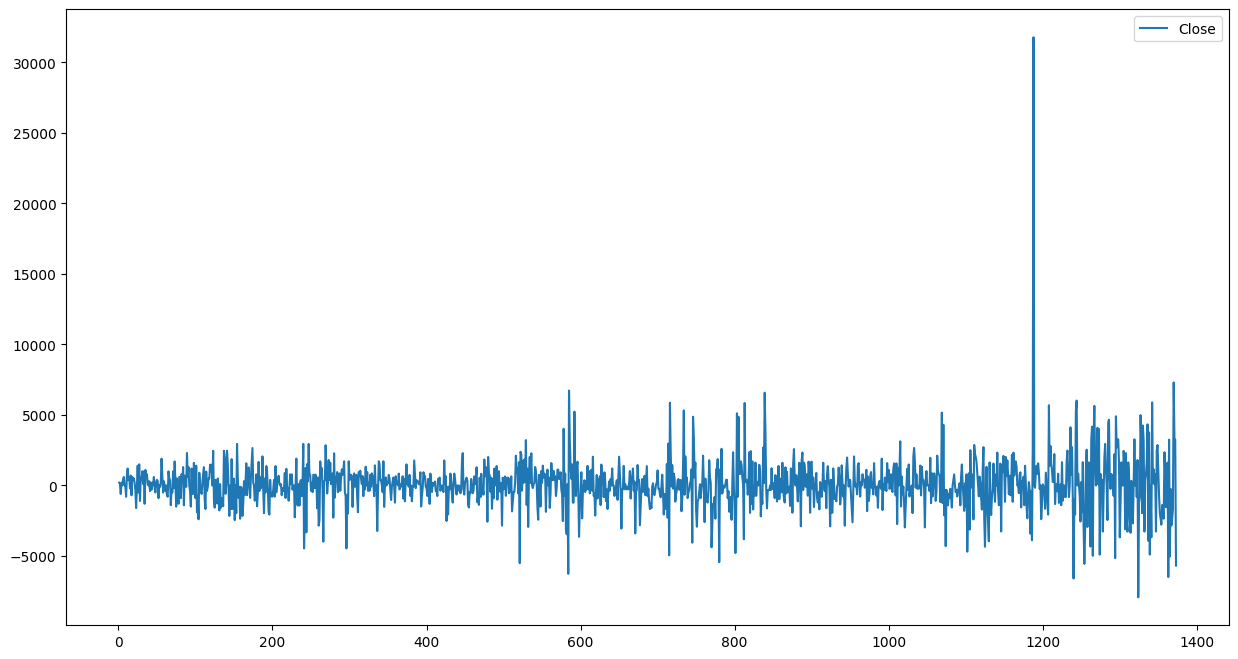

In [ ]:
df= df.diff().dropna()
df.plot(figsize=(15,8))

stationarity(df)

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

def pacf(col):
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))
    ax1.plot(col)
    ax1.set_title('The Column Diff')
    plot_pacf(col, method='ywm', ax=ax2);
    

def acf(col):
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))
    ax1.plot(col)
    ax1.set_title('The Column Diff')
    plot_acf(col, ax=ax2);

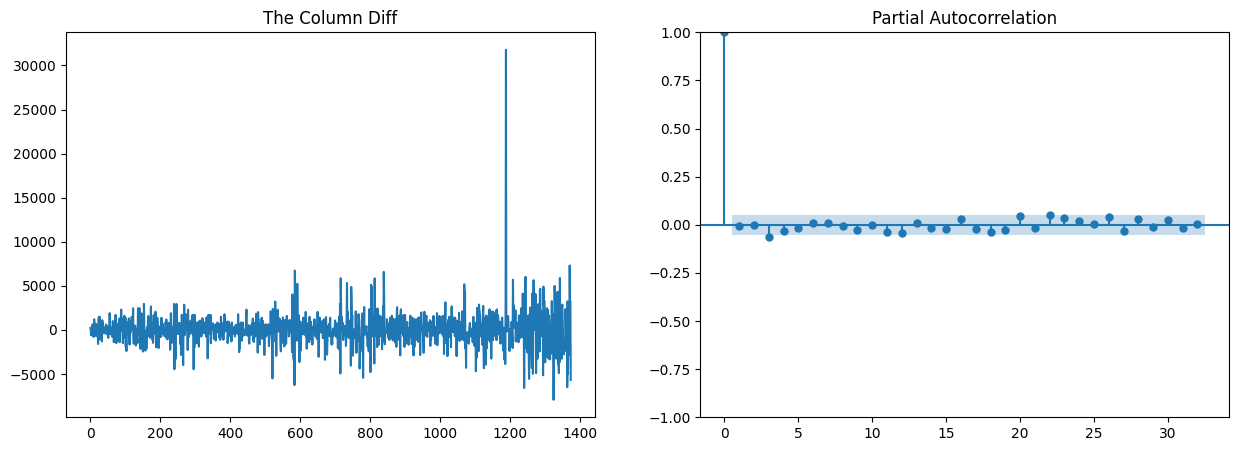

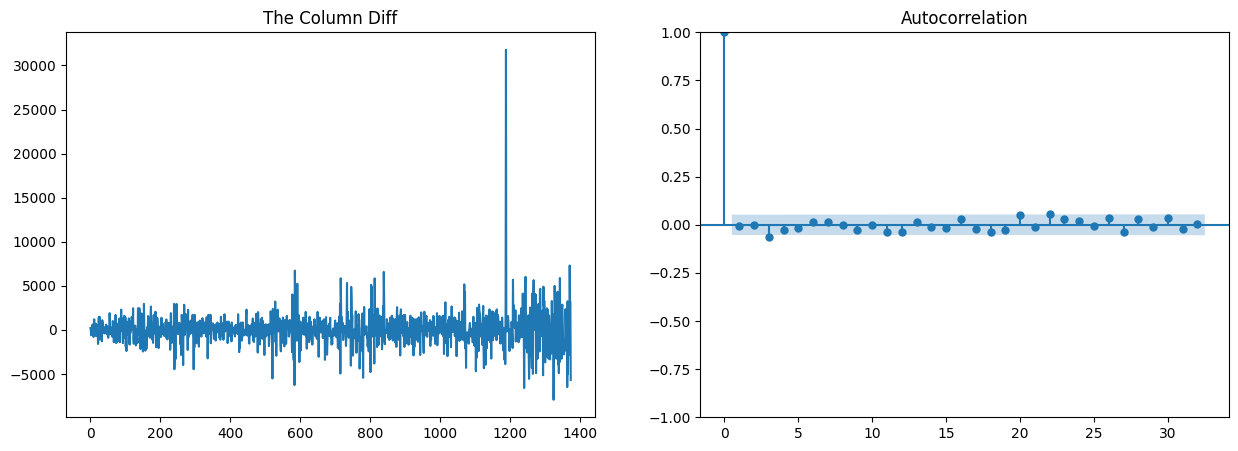

In [ ]:
pacf(df)
acf(df)

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 51.4 MB/s eta 0:00:00


In [ ]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=16550.678, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16544.663, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16546.021, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16546.046, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16543.204, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16547.206, Time=0.29 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.082 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  961
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -8270.602
Date:                Thu, 08 Jun 2023   AIC                          16543.204
Time:                        13:27:52   BIC                          16548.071
Sample:                             0   HQIC                         16545.058
                                - 961                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.779e+06   4.67e+04     38.111      0.000    1.69e+06    1.87e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.63   Jarque-Bera (JB):               652.64
Prob(Q):                              0.20   Prob(JB):                         0.00
Heteroskedasticity (H):               1.85   Skew:                             0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(n_periods=len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [ ]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[96599. 96599. 96599. 96599. 96599. 96599. 96599. 96599. 96599. 96599.
 96599. 96599. 96599. 96599. 96599. 96599. 96599. 96599. 96599. 96599.
 96599. 96599. 96599. 96599. 96599. 96599. 96599. 96599. 96599. 96599.]


In [ ]:
# 7. Đánh giá độ chính xác validate, test

# Độ sai lệch tuyệt đối phần trăm trung bình (Mean Absolute Percentage Error)
mape = np.mean(np.abs((y_val - y_pred_val) / y_val)) * 100
print("Validation MAPE:", mape)

# Độ lỗi bình phương trung bình (Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
print("Validation RMSE:", rmse)

# Độ sai lệch tuyệt đối trung bình (Mean Absolute Error)
mae = mean_absolute_error(y_val, y_pred_val)
print("Validation MAE:", mae)

print("==============================================================================")



# Độ lỗi bình phương trung bình (Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Testing RMSE:", rmse)

# Độ sai lệch tuyệt đối trung bình (Mean Absolute Error)
mae = mean_absolute_error(y_test, y_pred)
print("Testing MAE:", mae)

# Độ sai lệch tuyệt đối phần trăm trung bình (Mean Absolute Percentage Error)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print("Testing MAPE:", mape)




Validation MAPE: 38.5282377193901
Validation RMSE: 62570.7376037759
Validation MAE: 61456.02158273381
Testing RMSE: 17533.717836127464
Testing MAE: 11962.149635036496
Testing MAPE: 9.993812964510628


Validation RMSE: 62570.7376037759
Testing RMSE: 17533.717836127464


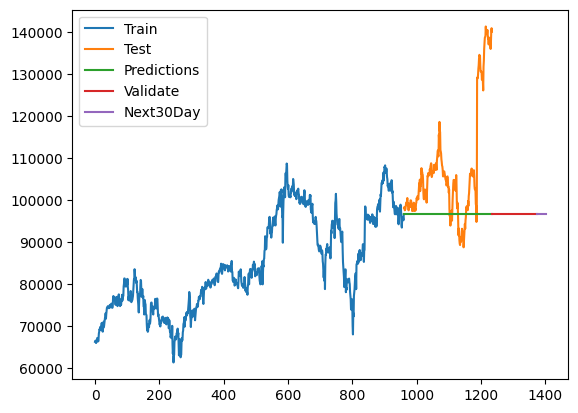

In [ ]:

# 9.Vẽ hình
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()